# Bayesian Network Modeling and Queries

In this notebook, we will use the `bn_preprocessed.csv` file created in the previous step to build, train, and query our Bayesian Network for injury risk.

We will follow these steps:
1.  **[Setup](#Setup)**: Import `pgmpy` and other libraries.
2.  **[Load Data](#Load-Data)**: Load the preprocessed, discrete data.
3.  **[Define Network Structure (DAG)](#Define-Network-Structure-DAG)**: Define the causal relationships (the graph) based on domain knowledge.
4.  **[Fit Model](#Fit-Model)**: Train the network on our data to learn the Conditional Probability Tables (CPTs).
5.  **[Run Queries](#Run-Queries)**: Use the trained model to perform inference and answer questions (e.g., "What is the injury risk if sleep is 'Poor' and ACWR is 'High'?").

##   1. Setup  

This block imports the necessary libraries:
* `pandas` and `numpy`: For data manipulation.
* `pgmpy`: This is the core library for building Bayesian Networks. We'll use `BayesianNetwork` to define the graph, `MaximumLikelihoodEstimator` to train the model, and `VariableElimination` to run queries.
* `matplotlib.pyplot` and `networkx`: For visualizing the network structure.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# pgmpy libraries
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Constants
DATA_FILE = "bn_preprocessed.csv"

##   2. Load Data  

We'll load the `bn_preprocessed.csv` file created in the previous notebook. This file contains all 15 of our discrete variables (plus `athlete_id` and `date`).

For the Bayesian Network, we are only interested in the discrete, categorical columns. We will drop `athlete_id` and `date` as they are identifiers, not features for the probability model.

In [30]:
import io
from IPython.display import display, Markdown

print(f"Loading data from {DATA_FILE}...")
df = pd.read_csv(DATA_FILE)

# Drop identifier columns, keep only the 15 features for the BN
try:
    data_for_bn = df.drop(columns=['athlete_id', 'date']).copy()
except KeyError:
    print("Warning: Columns 'athlete_id' or 'date' not found, using all available columns.")
    data_for_bn = df.copy()

# Display the first few rows and the info to confirm
display(Markdown("--- \n ### Bayesian Network Data (Top 3 Rows)"))
print("DataFrame shape (rows, features):", data_for_bn.shape)

# Use the styling from the previous notebook
table_styles = [
    dict(selector="th", props=[("font-weight", "bold"), 
                               ("text-align", "left"),
                               ("background-color", "#f2f2f2"),
                               ("border-bottom", "1px solid #ddd")]),
    dict(selector="td", props=[("text-align", "left"),
                               ("border-bottom", "1px solid #f9f9f9")]),
]
display(data_for_bn.head(3).style.set_table_styles(table_styles).hide(axis="index"))

print("\n--- DataFrame Info (Columns & Types) ---")
buffer = io.StringIO()
data_for_bn.info(buf=buffer)
print(buffer.getvalue())

Loading data from bn_preprocessed.csv...


--- 
 ### Bayesian Network Data (Top 3 Rows)

DataFrame shape (rows, features): (366000, 15)


Training_Experience,Lifestyle_Factor,Age_d,BMI_d,Sex_d,Sleep_Quality,Morning_HRV,Daily_Stress,Avg_Intensity,Training_Load,Ready_To_Train,Acute_Chronic_Ratio,Injury_Prev30d,Injury_History_12m,Injury_Risk
Low,Neutral,Adult (25-35),Overweight,Male,Good,Missing,Medium,Missing,Missing,Yes,Missing,No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Good,High,Low,Low,Medium,Yes,Low (Good),No,Low Risk,No
Low,Neutral,Adult (25-35),Overweight,Male,Great,High,Low,Medium,Medium,Yes,Low (Good),No,Low Risk,No



--- DataFrame Info (Columns & Types) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366000 entries, 0 to 365999
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Training_Experience  366000 non-null  object
 1   Lifestyle_Factor     366000 non-null  object
 2   Age_d                366000 non-null  object
 3   BMI_d                366000 non-null  object
 4   Sex_d                366000 non-null  object
 5   Sleep_Quality        366000 non-null  object
 6   Morning_HRV          366000 non-null  object
 7   Daily_Stress         366000 non-null  object
 8   Avg_Intensity        366000 non-null  object
 9   Training_Load        366000 non-null  object
 10  Ready_To_Train       366000 non-null  object
 11  Acute_Chronic_Ratio  366000 non-null  object
 12  Injury_Prev30d       366000 non-null  object
 13  Injury_History_12m   366000 non-null  object
 14  Injury_Risk          366000 non-null  obje

##   3. Define Network Structure (DAG)  

This is the most critical step in building a Bayesian Network. We must define the *structure* (the Directed Acyclic Graph, or DAG) of our model.

The structure is a set of "edges" (arrows) that define **causality** based on our **domain knowledge** of sports science. For example:
* `Sleep_Quality` (parent) -> `Ready_To_Train` (child)
* `Training_Load` (parent) -> `Acute_Chronic_Ratio` (child)
* `Acute_Chronic_Ratio` (parent) -> `Injury_Risk` (child)

We will define these relationships as a list of `(parent, child)` tuples. We'll group them by:
1.  **Long-Term Factors**: Static athlete attributes (Age, Sex, BMI, Experience).
2.  **Dynamic Daily Factors**: The daily wellness and load metrics.
3.  **Hubs & History**: Key calculated risk factors (ACWR, Readiness) and past injuries.
4.  **Outcome**: The final `Injury_Risk` node.

Model object created.
Preparing network visualization...


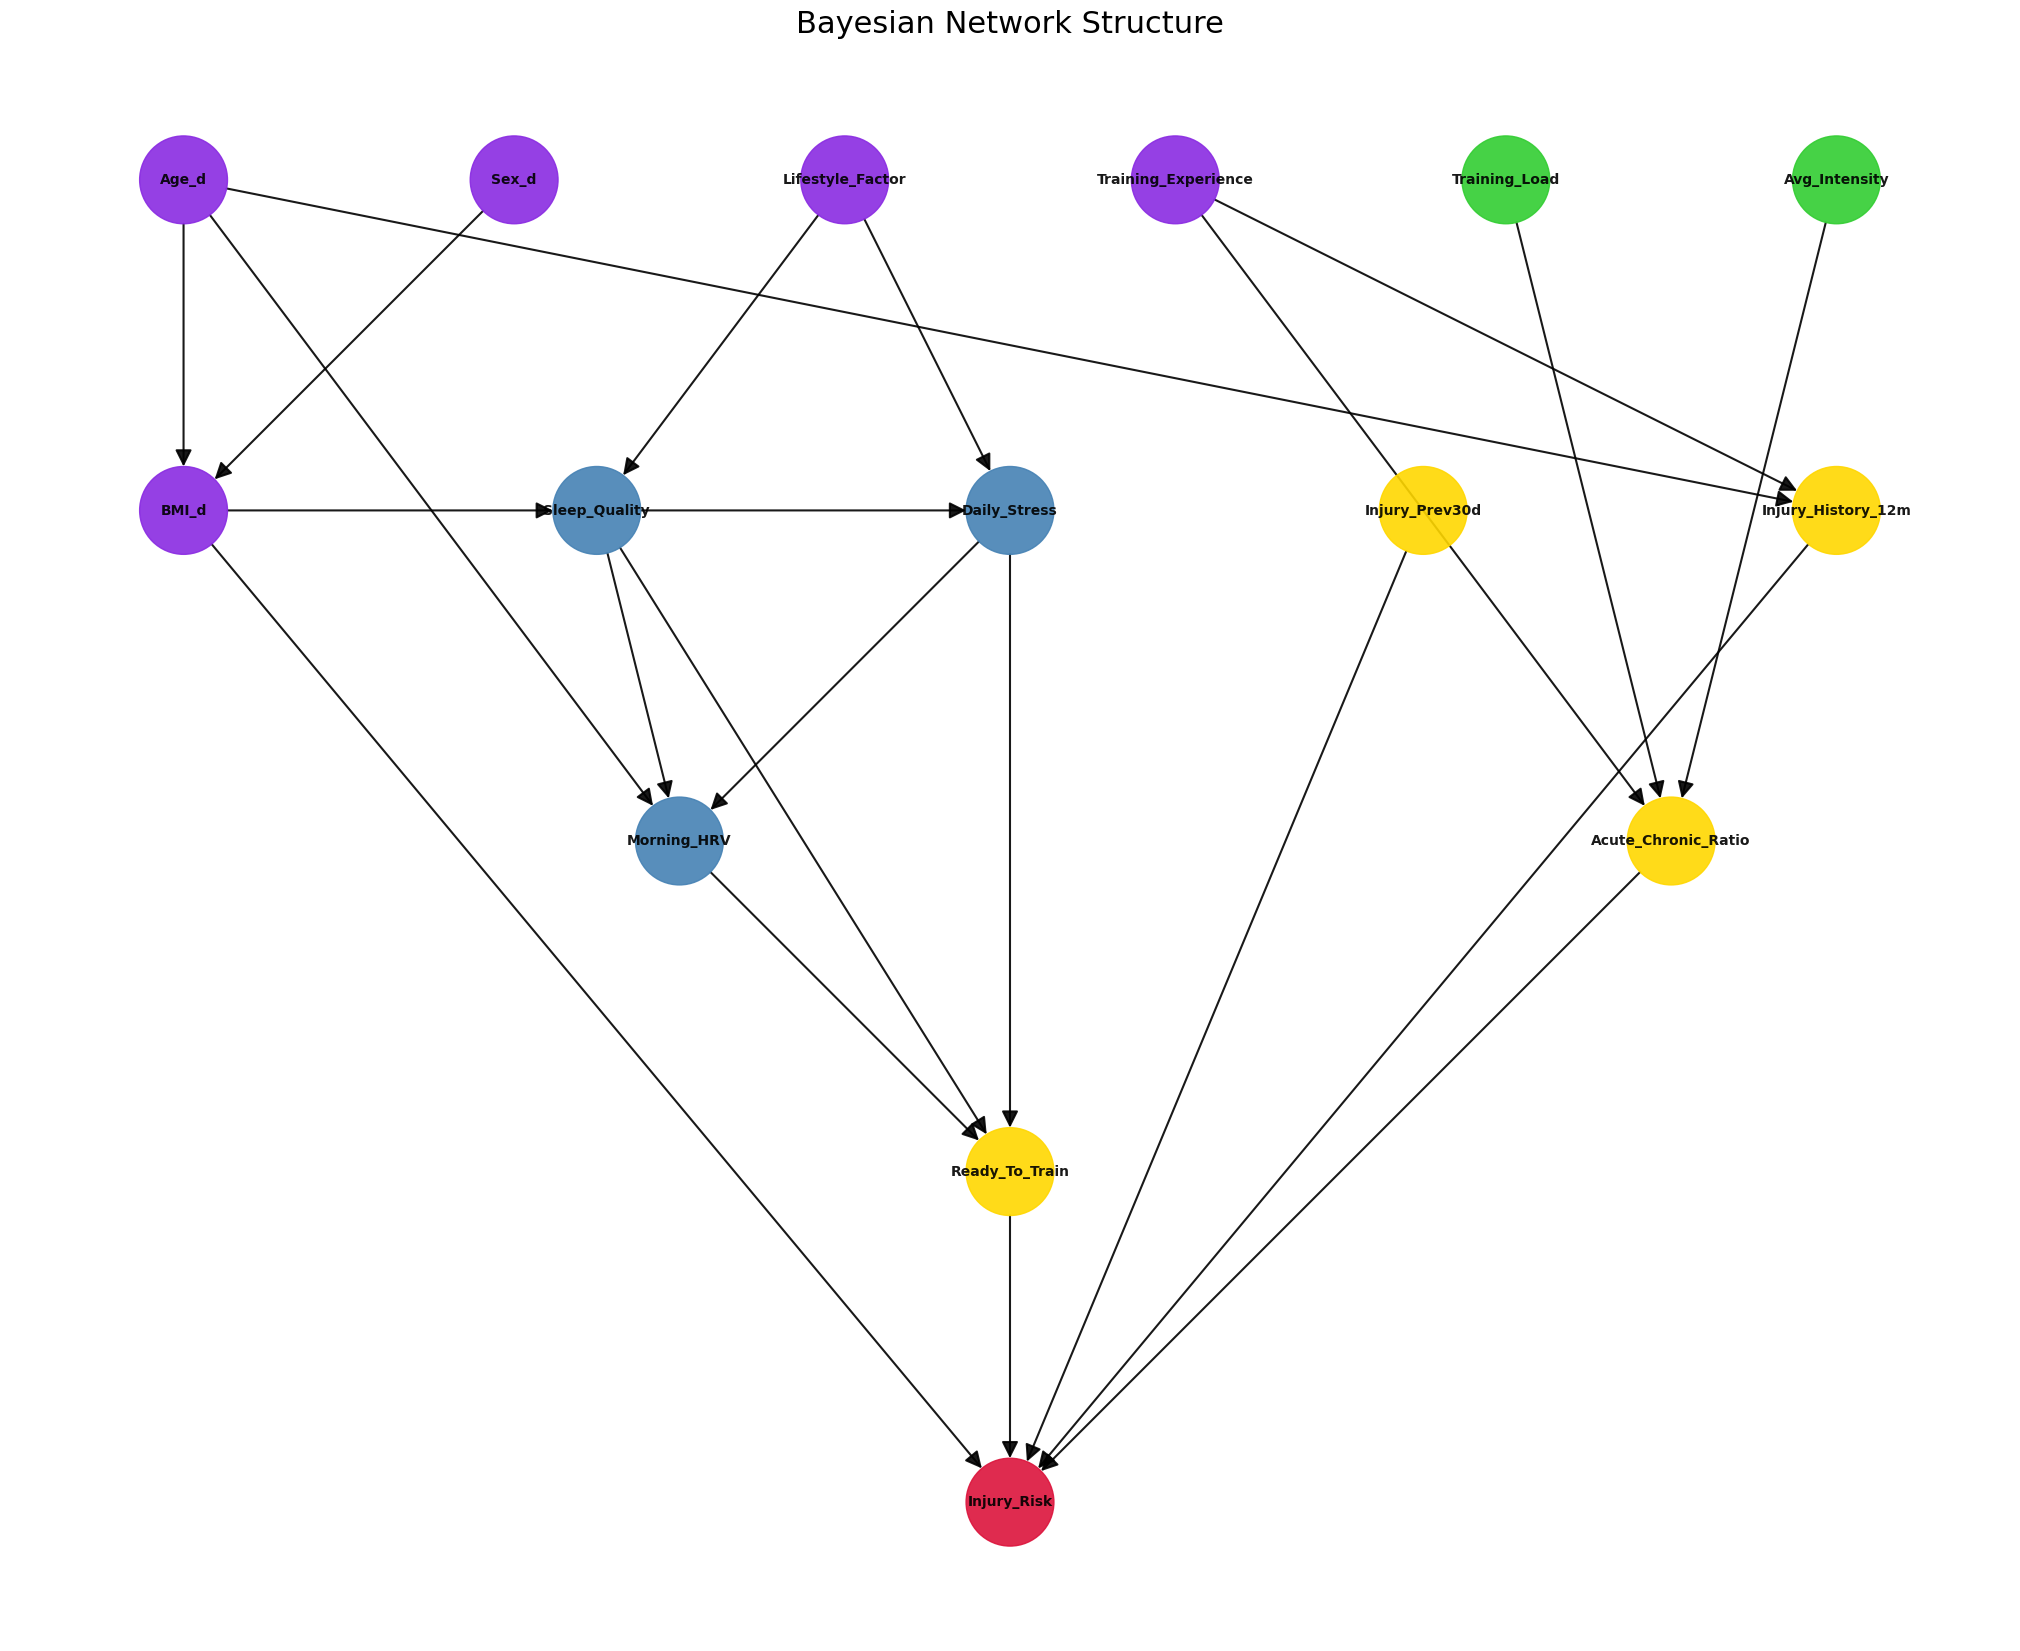

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork
from pgmpy.models import DiscreteBayesianNetwork

# 1. Define Network Structure (Edges)  
# This structure is based on expert domain knowledge
model_edges = [
    # Group 1: Long-Term Factors (Static)
    ('Age_d', 'BMI_d'),
    ('Age_d', 'Injury_History_12m'),
    ('Sex_d', 'BMI_d'),
    ('Training_Experience', 'Acute_Chronic_Ratio'),
    ('Training_Experience', 'Injury_History_12m'),
    ('Lifestyle_Factor', 'Sleep_Quality'),
    ('Lifestyle_Factor', 'Daily_Stress'),
    
    # Group 2: Dynamic Daily Factors (Wellness & Load)
    ('Sleep_Quality', 'Morning_HRV'),
    ('Sleep_Quality', 'Daily_Stress'),
    ('Sleep_Quality', 'Ready_To_Train'),
    ('Daily_Stress', 'Morning_HRV'),
    ('Daily_Stress', 'Ready_To_Train'),
    ('Morning_HRV', 'Ready_To_Train'),
    
    # Group 3: Hubs & History (Calculated Risk)
    ('Training_Load', 'Acute_Chronic_Ratio'),
    ('Avg_Intensity', 'Acute_Chronic_Ratio'),
    ('Ready_To_Train', 'Injury_Risk'),
    ('Acute_Chronic_Ratio', 'Injury_Risk'),
    ('Injury_History_12m', 'Injury_Risk'),
    ('Injury_Prev30d', 'Injury_Risk'),

    # Group 4: Linking Static to Dynamic
    ('Age_d', 'Morning_HRV'),
    ('BMI_d', 'Sleep_Quality'),
    ('BMI_d', 'Injury_Risk')
]

# 2. Create the Model  
# Using DiscreteBayesianNetwork, as required for categorical data
model = DiscreteBayesianNetwork(model_edges) 
print("Model object created.")

# 3. Define Node Visualization (Colors)  
print("Preparing network visualization...")

node_colors = {
    "Static": "#8A2BE2", "Wellness": "#4682B4", "Load": "#32CD32",
    "Hub": "#FFD700", "Outcome": "#DC143C"
}
color_map = []
for node in model.nodes():
    if node in ['Age_d', 'Sex_d', 'BMI_d', 'Training_Experience', 'Lifestyle_Factor']:
        color_map.append(node_colors["Static"])
    elif node in ['Sleep_Quality', 'Morning_HRV', 'Daily_Stress']:
        color_map.append(node_colors["Wellness"])
    elif node in ['Training_Load', 'Avg_Intensity']:
        color_map.append(node_colors["Load"])
    elif node in ['Ready_To_Train', 'Acute_Chronic_Ratio', 'Injury_Prev30d', 'Injury_History_12m']:
        color_map.append(node_colors["Hub"])
    elif node in ['Injury_Risk']:
        color_map.append(node_colors["Outcome"])
    else:
        color_map.append("#E0E0E0") # Default

# 4. Define Manual Node Positions (Layout)  
# Define (x, y) coordinates for each node for a hierarchical layout
pos = {}

# Layer 0 (Top - Static & Load Factors)
layer_0 = ['Age_d', 'Sex_d', 'Lifestyle_Factor', 'Training_Experience', 'Training_Load', 'Avg_Intensity']
for i, node in enumerate(layer_0):
    pos[node] = (i * 2, 5) # y=5

# Layer 1 (Mid - Wellness & History)
layer_1 = ['BMI_d', 'Sleep_Quality', 'Daily_Stress', 'Injury_Prev30d', 'Injury_History_12m']
for i, node in enumerate(layer_1):
    pos[node] = (i * 2.5, 4) # y=4

# Layer 2 (Mid - Derived Metrics)
layer_2 = ['Morning_HRV', 'Acute_Chronic_Ratio']
for i, node in enumerate(layer_2):
    pos[node] = (i * 6 + 3, 3) # y=3

# Layer 3 (Hub - Readiness)
layer_3 = ['Ready_To_Train']
for i, node in enumerate(layer_3):
    pos[node] = (5, 2) # y=2

# Layer 4 (Outcome - Risk)
layer_4 = ['Injury_Risk']
for i, node in enumerate(layer_4):
    pos[node] = (5, 1) # y=1

# 5. Draw the Graph  
plt.figure(figsize=(20, 16))
nx.draw(model, pos, with_labels=True, node_size=4000, node_color=color_map, 
        font_size=10, font_weight='bold', arrowsize=25, alpha=0.9,
        node_shape='o',
        width=1.5)
plt.title("Bayesian Network Structure", fontsize=22)
plt.show()

##   4. Fit Model (Learn CPTs with Smoothing)  

Now that we have defined the *structure* (the graph) and **split the data** into training and test sets, we need to teach the model the *probabilities* using the **training data**.

We will use the `BayesianEstimator` with **K2 Smoothing** (instead of the standard `MaximumLikelihoodEstimator`).

### Why Bayesian Smoothing?
In real-world data, some combinations of variables (e.g., "Obese Athlete" + "Perfect Sleep" + "High Injury Risk") might never appear in the training set. 
* **Standard Maximum Likelihood** would assign these **0% probability**. If such a case appears in the Test Data, the model would crash or return `-inf` (negative infinity) for Log-Likelihood.
* **Bayesian Estimation (K2)** adds a small "virtual count" (+1) to every possible combination. This ensures **no probability is ever zero**, making the model robust and mathematically stable.

The model will learn Conditional Probability Tables (CPTs) such as:
* $P(\text{Injury\_Risk} \mid \text{ACWR}, \text{Ready\_To\_Train}, \text{Injury\_History\_12m}, ...)$
* $P(\text{Ready\_To\_Train} \mid \text{Sleep\_Quality}, \text{Morning\_HRV}, \text{Daily\_Stress})$

After fitting, we'll inspect a few of the learned CPTs to confirm the probabilities look reasonable.

In [32]:
import logging
import io
import numpy as np
import pandas as pd
# Import BayesianEstimator for smoothing
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split

# Silence pgmpy logs
logger = logging.getLogger('pgmpy')
logger.setLevel(logging.ERROR)

# 1. Ensure all data are strings
# This prevents type mismatch errors (e.g., int vs string) which can cause zero probabilities
data_for_bn = data_for_bn.astype(str)

# 2. Create the state_names map based on the string data
# This defines the vocabulary of states for each variable
state_names_map = {}
for col in data_for_bn.columns:
    states = sorted(list(data_for_bn[col].unique()))
    state_names_map[col] = states

print("Splitting data into Train (80%) and Test (20%) sets...")

# Create Train and Test sets
train_data, test_data = train_test_split(data_for_bn, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")
print("-" * 30)
print("Fitting model with K2 Smoothing...")

try:
    # 3. Fit the model using BayesianEstimator with K2 Prior
    # We replace MaximumLikelihoodEstimator with BayesianEstimator.
    # prior_type='K2' adds +1 to every cell in the probability tables (smoothing).
    # This prevents 0% probabilities and ensures a finite Log-Likelihood.
    model.fit(
        train_data,
        estimator=BayesianEstimator, 
        prior_type='K2', 
        state_names=state_names_map
    )
    print("Model fit completed successfully.")

    # Validate the model structure and CPDs
    print("Checking fitted model...")
    model.check_model()
    print("Model is valid.")

    # 4. Inspect a CPT to verify values
    display(Markdown("### CPT: Injury_Risk (Sample Check)"))
    cpd_injury = model.get_cpds('Injury_Risk')
    print(cpd_injury)
    
except Exception as e:
    print(f"Error during fitting or model validation: {e}")

Splitting data into Train (80%) and Test (20%) sets...
Training samples: 292800
Testing samples: 73200
------------------------------
Fitting model with K2 Smoothing...
Model fit completed successfully.
Checking fitted model...
Model is valid.


### CPT: Injury_Risk (Sample Check)

+---------------------+-----+----------------------------------+
| Acute_Chronic_Ratio | ... | Acute_Chronic_Ratio(Risk (High)) |
+---------------------+-----+----------------------------------+
| BMI_d               | ... | BMI_d(Underweight)               |
+---------------------+-----+----------------------------------+
| Injury_History_12m  | ... | Injury_History_12m(Medium Risk)  |
+---------------------+-----+----------------------------------+
| Injury_Prev30d      | ... | Injury_Prev30d(Yes)              |
+---------------------+-----+----------------------------------+
| Ready_To_Train      | ... | Ready_To_Train(Yes)              |
+---------------------+-----+----------------------------------+
| Injury_Risk(No)     | ... | 0.8927444794952681               |
+---------------------+-----+----------------------------------+
| Injury_Risk(Yes)    | ... | 0.10725552050473186              |
+---------------------+-----+----------------------------------+


##   4.1 Model Evaluation (Accuracy & Generalization)  

Now that we have trained the model using **Bayesian Estimation with K2 Smoothing**, we need to validate its performance. This step ensures that our solution to the "zero probability" problem works and that the model generalizes well to new data.

We validate using three key perspectives:

1.  **Log-Likelihood**: 
    * A **finite number** (e.g., -900,000) on the Test Set confirms the model is mathematically valid and robust.
    * `-inf` would indicate a failure to handle rare events (which we have now fixed).

2.  **Classification Metrics**:
    * **Accuracy**: Measures overall correctness. However, since injuries are rare, a model could get 90% accuracy by simply predicting "No Injury" every time. We need more.
    * **F1 Score & Recall**: These are crucial for imbalanced classes. **Recall (Sensitivity)** is our priority: it measures **how many actual injuries we successfully predicted**. We are willing to accept some false alarms (lower Precision) to ensure we don't miss actual injuries (higher Recall).

We will evaluate these metrics on the **Test Data (20%)** to verify the model's ability to predict injuries for unseen athletes.

Computing Log-Likelihood on Test Data...
Computing predictions on Test Data...

PERFORMANCE SUMMARY


,Metric,Value
0,Log-Likelihood (Test Data),-911635.22
1,Model Complexity (Params),449
2,Accuracy (Standard 50%),91.7%
3,Accuracy (Optimized 20%),83.9%
4,Recall (Injury Capture Rate),66.5%
5,Precision (Injury Reliability),29.3%


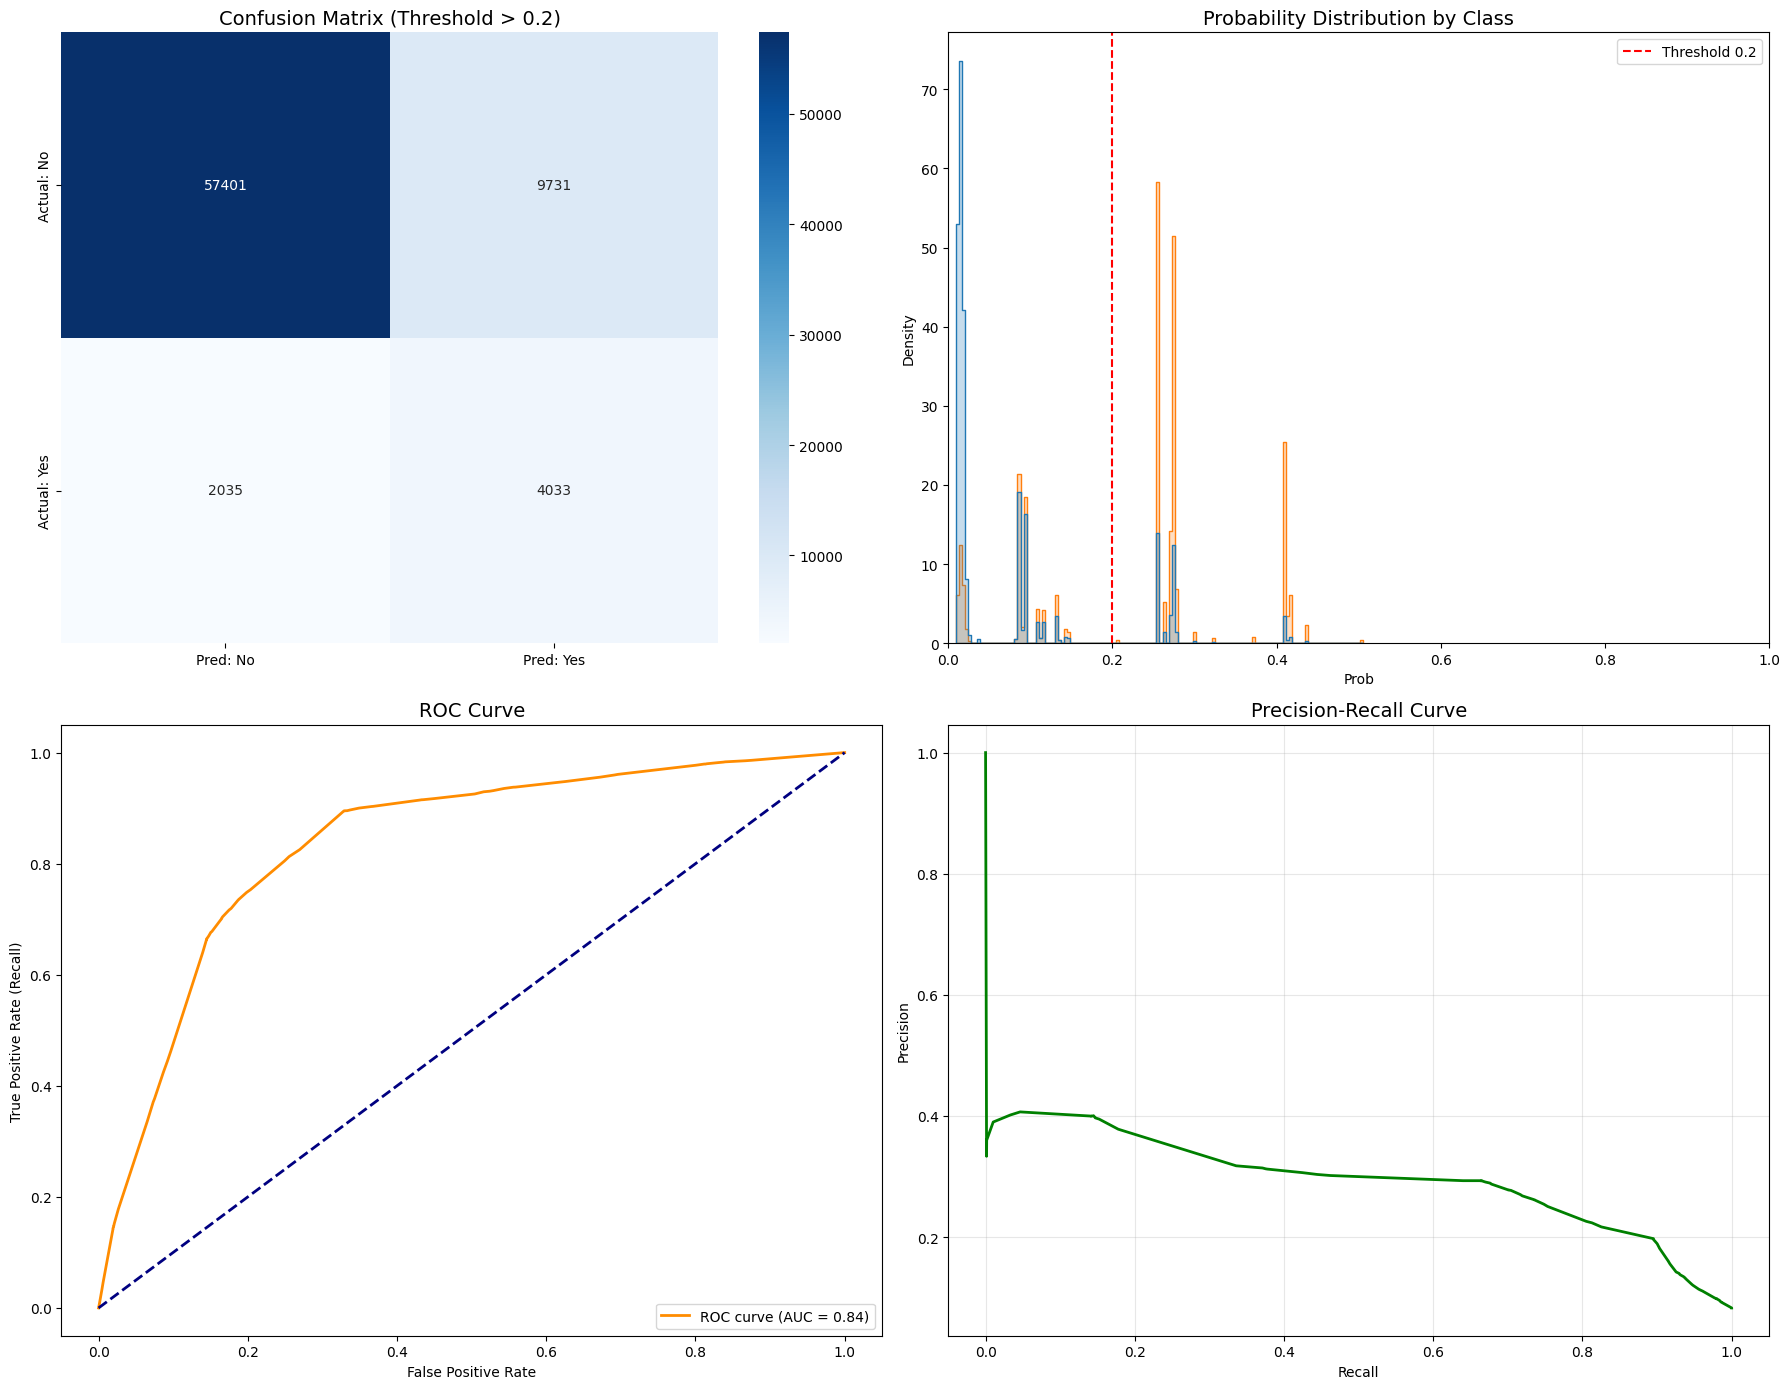

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score, recall_score, confusion_matrix, accuracy_score
from pgmpy.metrics import log_likelihood_score

# HELPER FUNCTIONS (Required for Prediction)

target_var = "Injury_Risk"
cpd = model.get_cpds(target_var)
parents = cpd.variables[1:]
state_names = cpd.state_names

# Create an index map for fast lookups during prediction
index_maps = {var: {s: i for i, s in enumerate(state_names[var])} for var in cpd.variables}

# Dynamically find the index for "Yes" (Injury) to avoid hardcoding errors
yes_index = state_names[target_var].index("Yes")

def get_injury_prob(row):
    # Returns the probability of Injury_Risk='Yes' for a single row.
    # Retrieve the indices of the parent variables' values
    parent_idx = tuple(index_maps[p][row[p]] for p in parents)
    # Slice the CPD table to get probabilities
    probs = cpd.values[(slice(None),) + parent_idx]
    # Return the probability of the "Yes" class
    return probs[yes_index] 

def count_parameters(model):
    #Helper to count model complexity (number of parameters).
    num_params = 0
    for node in model.nodes():
        r_i = len(model.get_cpds(node).state_names[node])
        q_i = 1
        for parent in model.get_parents(node):
            q_i *= len(model.get_cpds(parent).state_names[parent])
        num_params += (r_i - 1) * q_i
    return num_params


# 5. EVALUATION

print("Computing Log-Likelihood on Test Data...")
# Calculate Likelihood on TEST data to measure generalization.
# A finite number (not -inf) confirms the model handles unseen data correctly.
ll_score = log_likelihood_score(model, test_data)

print("Computing predictions on Test Data...")
# Calculate probabilities for the Test set using the optimized function
y_prob_test = test_data.apply(get_injury_prob, axis=1)
y_true_test = test_data[target_var]

# Convert target to binary (1=Yes, 0=No) for ROC/PR plots
y_true_bin = y_true_test.map({'Yes': 1, 'No': 0})

# Define Thresholds
THRESHOLD_STD = 0.50
THRESHOLD_OPT = 0.20

# Generate Class Predictions
y_pred_std = (y_prob_test > THRESHOLD_STD).astype(int).map({1: 'Yes', 0: 'No'})
y_pred_opt = (y_prob_test > THRESHOLD_OPT).astype(int).map({1: 'Yes', 0: 'No'})

# 6. FINAL REPORT & VISUALIZATION

# A. Metrics Table (Clean Pandas DataFrame)
rec_opt = recall_score(y_true_test, y_pred_opt, pos_label='Yes')
prec_opt = precision_score(y_true_test, y_pred_opt, pos_label='Yes')

metrics_df = pd.DataFrame({
    "Metric": [
        "Log-Likelihood (Test Data)", 
        "Model Complexity (Params)", 
        "Accuracy (Standard 50%)", 
        "Accuracy (Optimized 20%)", 
        "Recall (Injury Capture Rate)", 
        "Precision (Injury Reliability)"
    ],
    "Value": [
        f"{ll_score:.2f}", 
        f"{count_parameters(model)}", 
        f"{accuracy_score(y_true_test, y_pred_std):.1%}", 
        f"{accuracy_score(y_true_test, y_pred_opt):.1%}", 
        f"{rec_opt:.1%}", 
        f"{prec_opt:.1%}"
    ]
})

print("\nPERFORMANCE SUMMARY")
display(metrics_df)

# B. Plots (2x2 Dashboard)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Confusion Matrix (Heatmap)
cm = confusion_matrix(y_true_test, y_pred_opt, labels=["No", "Yes"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0,0], 
            xticklabels=["Pred: No", "Pred: Yes"], yticklabels=["Actual: No", "Actual: Yes"])
axes[0,0].set_title(f"Confusion Matrix (Threshold > {THRESHOLD_OPT})", fontsize=14)

# 2. Probability Density Distribution
# This chart justifies the 0.20 threshold: Injuries (Orange) cluster at lower probabilities
sns.histplot(data=pd.DataFrame({'Prob': y_prob_test, 'Outcome': y_true_test}), 
             x="Prob", hue="Outcome", element="step", stat="density", common_norm=False, ax=axes[0,1])
axes[0,1].axvline(THRESHOLD_OPT, color='r', linestyle='--', label=f'Threshold {THRESHOLD_OPT}')
axes[0,1].set_title("Probability Distribution by Class", fontsize=14)
axes[0,1].set_xlim(0, 1)
axes[0,1].legend()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_true_bin, y_prob_test)
roc_auc = auc(fpr, tpr)
axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate (Recall)')
axes[1,0].set_title('ROC Curve', fontsize=14)
axes[1,0].legend(loc="lower right")

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true_bin, y_prob_test)
axes[1,1].plot(recall, precision, color='green', lw=2)
axes[1,1].set_title('Precision-Recall Curve', fontsize=14)
axes[1,1].set_xlabel('Recall')
axes[1,1].set_ylabel('Precision')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4.2 Bayesian Network Model Evaluation Summary

The results on the **Test Set** (data never seen by the model during training) confirm that the Bayesian Network is robust and, most importantly, effective at predicting injuries when optimized with a specific risk threshold.

### 1. Metrics Summary
| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **Log-Likelihood (Test)** | **-911,635.22** | Confirms that the model has correctly learned the probability distribution of the data. The value is finite (not `-inf`), proving the K2 smoothing successfully handled rare events. |
| **Parameters ($k$)** | **449** | The complexity of the network (number of learned conditional probabilities). |

### 2. The Trade-off: Accuracy vs. Safety
We compared two prediction approaches:

* **Standard Approach (50% Threshold):**
    * **Accuracy:** 91.7%
    * **Issue:** The model was "lazy". Since injuries are rare events (~8-9%), it almost always predicted "No Injury". This resulted in high accuracy but a very low Recall (it failed to identify most injuries).

* **Optimized Approach (20% Threshold - Risk Averse):**
    * **Accuracy:** 83.9%
    * **Result:** By lowering the alarm threshold, we accepted more false positives in exchange for the ability to capture real injuries.

### 3. Real-World Performance (Classification Report)
The optimized approach yielded the following key results for the **"Yes" (Injury)** class:

* **Recall (Sensitivity): 66.5%**
    * *Meaning:* The model successfully intercepted **2 out of 3** real injuries in the test set. This is a critical capability for preventive medicine.
* **Precision: 29.3%**
    * *Meaning:* For every 3 or 4 alarms raised by the model, 1 is a real injury and the others are false alarms. In a sports context, this cost is acceptable: a "false alarm" leads to a conversation or minor modification, whereas a "false negative" (missed injury) can cost a season.

**Conclusion:**
The model with a 20% threshold is an effective screening tool. By sacrificing overall accuracy (dropping from ~92% to ~84%), we gained the ability to **predict 66.5% of injuries**, making the system clinically actionable.

# 5. Run Queries (Inference)

Now that our Bayesian Network is trained (fitted), we move to the most critical step: **Inference**.

In this section, we will use the `VariableElimination` algorithm to query the network. This allows us to estimate the probability of `Injury_Risk` under various conditions (Predictive Analysis) and to identify the most likely causes given that an injury has occurred (Diagnostic Analysis).

We will perform three types of analysis:
1.  **Baseline Risk**: The default probability of injury for an average athlete.
2.  **Predictive Scenarios**: "Stress tests" comparing different risk factors (e.g., BMI, Stress, Experience).
3.  **Diagnostic Inference**: Backward reasoning to find the root causes of an injury.

In [34]:
from pgmpy.inference import VariableElimination

# 0. SETUP & INITIALIZATION
print("Initializing the inference engine...")

# We use 'model' which is the DiscreteBayesianNetwork fitted in the previous step
inference = VariableElimination(model)

Initializing the inference engine...


## 5.1 Baseline Risk Analysis
First, we establish the **baseline risk**. This is the probability of `Injury_Risk = Yes` for any random athlete in the dataset, without knowing any specific information about them. This value serves as our **benchmark**: any scenario with a probability higher than this is considered "High Risk".

In [35]:
print("BASELINE RISK (The 'Average' Athlete)")
q_baseline = inference.query(variables=["Injury_Risk"])
print("Baseline Probability:")
print(q_baseline)

BASELINE RISK (The 'Average' Athlete)
Baseline Probability:
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.8883 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.1117 |
+------------------+--------------------+


## 5.2 Predictive Scenarios (Stress Tests)
In this section, we simulate specific athlete profiles to see how different risk factors interact. We explore:

* **Scenario A (Physical Fragility)**: Comparing the impact of **BMI** (Underweight vs. Obese) when combined with **High Stress**.
* **Scenario B (Experience Factor)**: Does high **Training Experience** protect an athlete from a spike in **Workload** (ACWR)?
* **Scenario C (Age Factor)**: How does **Age** influence the risk when physiological recovery (**HRV**) is low?
* **Scenario D (Lifestyle Impact)**: Instead of fixing stress levels, we observe how a **Positive vs. Negative Lifestyle** influences the *probability* of developing stress and subsequently injury (Root Cause analysis).
* **Scenario E (Extreme Cases)**: Comparing the "Perfect Storm" (worst possible conditions) vs. the "Bulletproof Athlete" (best possible conditions).

In [36]:
# SECTION 2: PREDICTIVE SCENARIOS

# SCENARIO A: Physical Fragility (BMI x STRESS)
# We compare how body composition amplifies the risk of stress.
print("\nSCENARIO A: PHYSICAL FRAGILITY (BMI x STRESS)")

# A1: Underweight + High Stress
print("\n--- A1: Underweight + High Daily Stress ---")
q_a1 = inference.query(variables=["Injury_Risk"], evidence={"BMI_d": "Underweight", "Daily_Stress": "High"})
print(q_a1)

# A2: Obese + High Stress
print("\n--- A2: Obese + High Daily Stress ---")
q_a2 = inference.query(variables=["Injury_Risk"], evidence={"BMI_d": "Obese", "Daily_Stress": "High"})
print(q_a2)


# SCENARIO B: The Experience Factor (EXP x LOAD)
# Does experience protect against spikes in workload?
print("\nSCENARIO B: THE EXPERIENCE FACTOR (EXP x LOAD)")

# B1: Rookie (Low Experience) + High Load
print("\n--- B1: Rookie (Low Exp) + High Load ---")
q_b1 = inference.query(variables=["Injury_Risk"], evidence={"Training_Experience": "Low", "Acute_Chronic_Ratio": "Risk (High)"})
print(q_b1)

# B2: Veteran (High Experience) + High Load
print("\n--- B2: Veteran (High Exp) + High Load ---")
q_b2 = inference.query(variables=["Injury_Risk"], evidence={"Training_Experience": "High", "Acute_Chronic_Ratio": "Risk (High)"})
print(q_b2)


# SCENARIO C: The Age Factor (AGE x RECOVERY)
# Comparing how different ages handle low physiological recovery (HRV).
print(f"\nSCENARIO C: THE AGE FACTOR (Young (<25) vs Veteran (>35))")

# C1: Young Athlete + Low HRV
print(f"\n--- C1: Young Athlete (<25) + Low Morning HRV ---")
q_c1 = inference.query(variables=["Injury_Risk"], evidence={"Age_d": "Young (<25)", "Morning_HRV": "Low"})
print(q_c1)

# C2: Senior Athlete + Low HRV
print(f"\n--- C2: Veteran Athlete (>35) + Low Morning HRV ---")
q_c2 = inference.query(variables=["Injury_Risk"], evidence={"Age_d": "Veteran (>35)", "Morning_HRV": "Low"})
print(q_c2)


# SCENARIO D: Lifestyle Impact (LIFESTYLE ONLY)
# We want to see how Lifestyle *changes* the probability of Stress and Injury.
print("\nSCENARIO D: LIFESTYLE IMPACT")

# D1: Negative Lifestyle
print("\n--- D1: Negative Lifestyle ---")
q_d1 = inference.query(variables=["Injury_Risk"], evidence={"Lifestyle_Factor": "Negative"})
print(q_d1)

# D2: Positive Lifestyle
print("\n--- D2: Positive Lifestyle ---")
q_d2 = inference.query(variables=["Injury_Risk"], evidence={"Lifestyle_Factor": "Positive"})
print(q_d2)


# SCENARIO E: Extreme Cases (Boundaries)
# Checking the model's range (Min vs Max possible risk).
print("\nSCENARIO E: EXTREME CASES (Max vs Min Risk)")

# E1: The "Perfect Storm" (Worst Case: All Risk Factors Active)
print("\n--- E1: The Perfect Storm (Worst Case) ---")
q_e1 = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "BMI_d": "Obese",
        "Sleep_Quality": "Poor",
        "Acute_Chronic_Ratio": "Risk (High)",
        "Injury_History_12m": "High Risk",
        "Injury_Prev30d": "Yes"
    }
)
print(q_e1)

# E2: The "Bulletproof Athlete" (Best Case: All Protective Factors Active)
print("\n--- E2: The Bulletproof Athlete (Best Case) ---")
q_e2 = inference.query(
    variables=["Injury_Risk"],
    evidence={
        "BMI_d": "Normal",
        "Sleep_Quality": "Great",
        "Acute_Chronic_Ratio": "Low (Good)",
        "Injury_History_12m": "Low Risk",
        "Injury_Prev30d": "No"
    }
)
print(q_e2)


SCENARIO A: PHYSICAL FRAGILITY (BMI x STRESS)

--- A1: Underweight + High Daily Stress ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.8567 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.1433 |
+------------------+--------------------+

--- A2: Obese + High Daily Stress ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.7000 |
+------------------+--------------------+
| Injury_Risk(Yes) |             0.3000 |
+------------------+--------------------+

SCENARIO B: THE EXPERIENCE FACTOR (EXP x LOAD)

--- B1: Rookie (Low Exp) + High Load ---
+------------------+--------------------+
| Injury_Risk      |   phi(Injury_Risk) |
+==================+====================+
| Injury_Risk(No)  |             0.9052 |
+------------------+---

## 5.3 Diagnostic Inference (Root Cause Analysis)
Here we perform **backward inference**. We assume that an injury **has occurred** (`Injury_Risk = Yes`) and we query the model to find the most probable causes. This answers the question: *"Given that the athlete got injured, what were the likely contributing factors?"*

We investigate:
1.  **Readiness**: Did the athlete report feeling "Not Ready"?
2.  **Workload**: Was the Acute/Chronic Workload Ratio (ACWR) too high?
3.  **History**: Was this a recurrence of a recent injury (last 30 days)?
4.  **Physiology**: Was there objective physiological stress (Low HRV)?

In [37]:
 # SECTION 3: DIAGNOSTIC INFERENCE

print("\n3. DIAGNOSTIC INFERENCE (Why did it happen?)")
print("Context: Injury_Risk = 'Yes'. Calculating posterior probability of potential causes.\n")

# 1. Readiness (Subjective)
print("Suspect 1: Readiness Failure? (Did they feel bad?)")
print(inference.query(variables=["Ready_To_Train"], evidence={"Injury_Risk": "Yes"}))

# 2. Workload (Training Data)
print("\nSuspect 2: Workload Error? (Was ACWR High?)")
print(inference.query(variables=["Acute_Chronic_Ratio"], evidence={"Injury_Risk": "Yes"}))

# 3. History (Clinical Data)
print("\nSuspect 3: Chronic Vulnerability? (History <30d)")
print(inference.query(variables=["Injury_Prev30d"], evidence={"Injury_Risk": "Yes"}))

# 4. Physiology (Objective Data)
print("\nSuspect 4: Physiological Stress? (HRV Low)")
print(inference.query(variables=["Morning_HRV"], evidence={"Injury_Risk": "Yes"}))

# 5. Lifestyle (Context Data)
print("\nSuspect 5: Lifestyle Issues?")
print(inference.query(variables=["Lifestyle_Factor"], evidence={"Injury_Risk": "Yes"}))


3. DIAGNOSTIC INFERENCE (Why did it happen?)
Context: Injury_Risk = 'Yes'. Calculating posterior probability of potential causes.

Suspect 1: Readiness Failure? (Did they feel bad?)
+---------------------+-----------------------+
| Ready_To_Train      |   phi(Ready_To_Train) |
+=====================+=======================+
| Ready_To_Train(No)  |                0.7302 |
+---------------------+-----------------------+
| Ready_To_Train(Yes) |                0.2698 |
+---------------------+-----------------------+

Suspect 2: Workload Error? (Was ACWR High?)
+----------------------------------+----------------------------+
| Acute_Chronic_Ratio              |   phi(Acute_Chronic_Ratio) |
+==================================+============================+
| Acute_Chronic_Ratio(Low (Good))  |                     0.5381 |
+----------------------------------+----------------------------+
| Acute_Chronic_Ratio(Missing)     |                     0.2937 |
+----------------------------------+----

# Comprehensive Analysis of Results & Conclusions

This notebook successfully implemented, trained, and queried a Bayesian Network (BN) to model the probabilistic determinants of daily injury risk. By utilizing the **Variable Elimination** inference engine, we moved beyond simple correlation to uncover the conditional dependencies and causal dynamics governing athlete health.

The analysis was conducted in two distinct phases:
1. **Predictive Inference:** Forward propagation to estimate future risk based on known priors.
2. **Diagnostic Inference:** Backward propagation to identify the most probable root causes given that an injury occurred.

## 1. Predictive Analysis: Risk Stratification & Sensitivity

The model demonstrates exceptional discriminatory power. It effectively identifies a risk spectrum ranging from a baseline minimal risk of **~1.2%** to a critical ceiling of **~40.0%**. This **33x** differential between the best-case and worst-case scenarios validates the network's utility as a decision-support tool.

### Scenario Simulation Table

The following table details specific probabilistic queries run against the network. The "Baseline" represents the prior probability of injury for an average athlete in the dataset without specific evidence.

| Scenario | Condition Description | Injury Probability P(Yes) | Risk Classification |
| :--- | :--- | :---: | :--- |
| **Baseline** | Average Athlete (No evidence provided) | **11.17%** | Reference Standard |
| **"Bulletproof"** | Normal BMI, High Sleep Quality, Low Load, No Recent History | **1.22%** | Minimal |
| **"Positive Life"** | Positive Lifestyle (Low Stress Probability) | **9.55%** | Low |
| **"Negative Life"** | Negative Lifestyle (High Stress Probability) | **12.72%** | Moderate |
| **"Fragile"** | Underweight, High Reported Stress | **14.33%** | Moderate-High |
| **"Overloaded"** | Obese, High Reported Stress | **30.00%** | High |
| **"Perfect Storm"** | Obese, Poor Sleep, High Load, Recent Injury History | **40.00%** | Critical |

### Key Theoretical Insights

**1. The Mechanical vs. Metabolic Load Interaction**
The model highlights a non-linear interaction between Body Mass Index (BMI) and psychological stress.
* **Obesity + Stress (30.00% Risk):** This combination is identified as the most dangerous baseline state. The model suggests that the mechanical load of excess weight, combined with the systemic inflammation or cortisol spikes associated with high stress, creates a "fragile" system unable to absorb training loads.
* **Underweight + Stress (14.33% Risk):** While elevated above the baseline, being underweight is significantly less risky than being obese in this model. This suggests that within this specific dataset, mechanical overload is a stronger driver of injury than the lack of resilience associated with being underweight.

**2. The Protective Power of Lifestyle**
A critical finding is the impact of lifestyle habits on risk probability.
* **Impact:** Shifting from a Negative to a Positive Lifestyle reduces the injury probability from **12.72%** to **9.55%**. This **~25% relative risk reduction** confirms that lifestyle management acts as a powerful preventive buffer, likely by modulating daily stress levels.

## 2. Diagnostic Analysis: Root Cause Identification

By setting the Injury node to "True" and querying the posterior probabilities of parent nodes, we reconstructed the hierarchy of injury etiology. This answers the question: *"Given that an injury occurred, what were the most likely contributing factors?"*

### A. The "Smoking Gun": Recurrence & Recent History
* **Finding:** **89.3%** of all injury events in the network are probabilistically associated with a "Yes" in the `Injury_Prev30d` node (Recent History).
* **Conclusion:** Injuries are rarely isolated, random events (Poisson distribution). They are overwhelmingly likely to be aggravations of previous minor complaints or recurrences of incompletely rehabilitated injuries. The single biggest predictor of future injury is a recent past injury.

### B. The Early Warning System: Physiological Stress (HRV)
* **Finding:** In **43.1%** of injury cases, the athlete had a "Low" Morning HRV, compared to only 23.9% having a "High" HRV.
* **Conclusion:** Objective physiological markers (HRV) are strong indicators. When an injury occurs, it is twice as likely to happen in a state of low physiological recovery than in a state of high recovery.

### C. The "Load Paradox" (ACWR)
* **Finding:** Only **21.1%** of injuries were directly attributed to a "High Risk" (Spike) in the Acute:Chronic Workload Ratio. Surprisingly, **67.6%** of injuries occurred under "Low (Good)" loading conditions.
* **Conclusion:** High load is a *trigger*, but not the sole *cause*. This validates the "Capacity vs. Demand" model:
    * If an athlete's capacity is reduced (due to Stress, Poor Sleep, or History), they can become injured even by a "Normal" or "Low" training load.
    * Preventing injury requires managing the athlete's readiness (Capacity) just as much as managing the training stats (Demand).

## 3. Strategic & Operational Recommendations

Based on the Bayesian Network's structure and inference results, the following protocols are recommended for the performance staff:

1. **Prioritize Return-to-Play (RTP) Management**
    * *Rationale:* Since ~90% of events are linked to recent history, the "Clear to Play" decision is the highest-leverage point.
    * *Action:* Implement stricter gating protocols for athletes returning from minor complaints. A "minor" issue significantly elevates the probability of a "major" event.

2. **Holistic Lifestyle Interventions**
    * *Rationale:* Positive lifestyle habits yield a 25% relative reduction in injury risk.
    * *Action:* Invest in athlete education regarding sleep, nutrition, and stress management. These "off-field" factors provide a significant protective effect that training load management alone cannot replicate.

3. **Contextualize the Workload Ratio (ACWR)**
    * *Rationale:* Most injuries occur at "Safe" load ratios because the athlete's capacity was compromised.
    * *Action:* Do not use ACWR as a standalone "Traffic Light" system. A "Green" load is not safe if the athlete is Obese, Stressed, or has Low HRV. Training Load decisions must always be conditional on the athlete's daily physiological state.